In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import shapiro, anderson, boxcox
import numpy as np
import math
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Definição de constantes

In [4]:
l_drop = [#'rotulo',
          'id_reforma',
          'sdv002',
          'sdc002',
          #'mdv001_1',
          #'mdv001_2',
          #'mdv001_3',
          #'mdv001_4',
          'sdu001_1',
          'sdu001_2',
          'TipoAlarmeReleResistencia_id_tipo',
          'TipoAlarmeResistencia_id_tipo',
          'id_reacao','data_hora_reforma'
          ]

d_rename = {'sdp002':'pressure',
            'sdt002':'reactor temperature',
            'sdt003':'pre-reactor temperature',
            'sdu002_1':'humidity',
            'sdu002_2':'local temperature',
            'rotulo': 'label',
            'mdv001_1':'outlet pressure',
            'mdv001_2':'volume flow',
            'mdv001_3':'mass flow',
            'mdv001_4':'outlet temperature'
            }

l_available = ['pressure',
               'reactor temperature',
               'pre-reactor temperature',
               'humidity',
               'local temperature',
               'label']
l_missing = ['outlet pressure',
             'volume flow',
             'mass flow',
             'outlet temperature']

l_new_avaliable = ['number data', 'SMA pressure forecast']

SMA_period  = 10 #


In [7]:
def recordsMinute(df):

    df['timestamp'] = pd.to_datetime(df['data_hora_reforma'], errors='coerce')
    # Verificando o tipo após a conversão


    df.set_index('timestamp', inplace=True)

    counts_per_minute = df.resample('min').size()

    media_registros_por_minuto = counts_per_minute.mean()

    count = counts_per_minute.describe()
    df = df.reset_index(drop=True)
    return count, df


Leitura dos dados

In [8]:
dir = '/content/drive/MyDrive/data/BASES/finalVersion/'
dfs = []
days = []
dfs_flow = []
days_flow = []
l_reg_minute = []
for i in (17,21,22,23,24,26,27,30,39):
  df = pd.read_csv(dir+'base'+str(i)+'_noFilter.csv')
  day= df['data_hora_reforma'].str[:10][0]
  days.append(day)
  count, df = recordsMinute(df)#
  l_reg_minute.append(count)#
  df = df.drop(l_drop, axis=1)
  df = df.rename(columns=d_rename)
  df['number data'] = range(len(df))
  df['SMA pressure forecast'] = df['pressure'].shift(-SMA_period).rolling(SMA_period).mean()
  if df['outlet pressure'][0] != -1:
    dfs_flow.append(df)
    days_flow.append(day)
  df = df[l_available + l_new_avaliable]
  dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all_flow = pd.concat(dfs_flow, ignore_index=True)


Análise da quantidade de registros por mintuto nas bases.
- A média 2.45, mas a mediana 2.88 e o 3º quartil (75%) teve 3 registros por minuto
- Para fazer uma previsão de 3 minutos, é necessário avançar aproximadamente 8 registros a frente.
- Também é necessário considerar que existem minutos nas bases que não há registros.

In [ ]:
dfCountRegMinute = pd.DataFrame(data=l_reg_minute)
dfCountRegMinute

,count,mean,std,min,25%,50%,75%,max
0,556.0,2.510791,0.672410,0.0,2.0,3.0,3.0,3.0
1,563.0,2.383659,0.814820,0.0,2.0,3.0,3.0,3.0
2,511.0,2.217221,0.969019,0.0,2.0,2.0,3.0,3.0
3,1846.0,2.331528,0.897182,0.0,2.0,3.0,3.0,3.0
4,2223.0,2.535762,0.589782,0.0,2.0,3.0,3.0,3.0
5,2766.0,2.542661,0.583828,0.0,2.0,3.0,3.0,3.0
6,584.0,2.544521,0.586940,0.0,2.0,3.0,3.0,3.0
7,660.0,2.539394,0.588168,0.0,2.0,3.0,3.0,3.0
8,815.0,2.526380,0.587736,1.0,2.0,3.0,3.0,3.0


Análise Descritiva
- Estatísticas descritivas são apresentadas para os dois dataFrames, sem e com vazão: a contagem de valores, a média, a medida padronizada do desvio da variável em relação à média e o valor de cada quartil, incluindo os valores mínimo e máximo.

In [ ]:
df_all.describe()

,pressure,reactor temperature,pre-reactor temperature,humidity,local temperature,label,number data,SMA pressure forecast
count,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,26066.000000,25895.000000
mean,0.582487,707.203675,573.946098,58.369316,27.926260,0.974373,2187.280941,0.583622
std,0.377408,233.057287,190.907700,28.143206,2.754604,0.793385,1808.490044,0.375821
min,0.340000,18.000000,20.000000,12.400000,22.400000,0.000000,0.000000,0.340000
25%,0.380000,796.000000,650.000000,31.500000,26.000000,0.000000,724.000000,0.380000
50%,0.430000,797.000000,650.000000,58.200000,27.100000,1.000000,1535.000000,0.435000
75%,0.590000,801.000000,650.000000,87.600000,29.300000,2.000000,3485.000000,0.589000
max,2.580000,806.000000,654.000000,99.000000,43.400000,2.000000,7032.000000,2.572000


In [ ]:
for d in dfs:
  print(d.describe())

In [ ]:
df_all_flow.describe()

,outlet pressure,volume flow,mass flow,outlet temperature,pressure,reactor temperature,pre-reactor temperature,humidity,local temperature,label,number data,SMA pressure forecast
count,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3871.000000,3814.000000
mean,1.100740,1.163524,1.027099,24.795709,0.561348,725.326531,584.696203,83.837716,29.472953,0.507879,649.650995,0.563268
std,0.280394,2.081705,2.063051,2.225254,0.303146,191.732088,163.139227,10.465919,2.805395,0.744230,380.747619,0.299666
min,0.967000,-0.600000,-0.400000,17.180000,0.340000,20.000000,20.000000,21.500000,24.400000,0.000000,0.000000,0.345000
25%,0.973000,0.200000,0.200000,23.340000,0.360000,796.000000,650.000000,80.300000,27.700000,0.000000,322.000000,0.360000
50%,0.974000,0.200000,0.200000,25.050000,0.430000,799.000000,650.000000,85.800000,29.100000,0.000000,645.000000,0.434000
75%,0.975000,1.400000,0.800000,26.540000,0.590000,802.000000,650.000000,89.750000,30.500000,1.000000,967.000000,0.622500
max,2.046000,18.800000,19.400000,28.380000,1.560000,806.000000,654.000000,96.100000,38.700000,2.000000,1395.000000,1.505000


Dados atípicos

- O valores de temperatura do reator se mantem constantes durante quase todo o periodo operacional, tendo sua variação durante o aquecimento e o desligamento das resistencias, por isso tal representação discrepante.
- Já a pressão nos apresenta valores discrepantes conforme aumenta, tal aumento é devido ao entupimento da linha de gás.

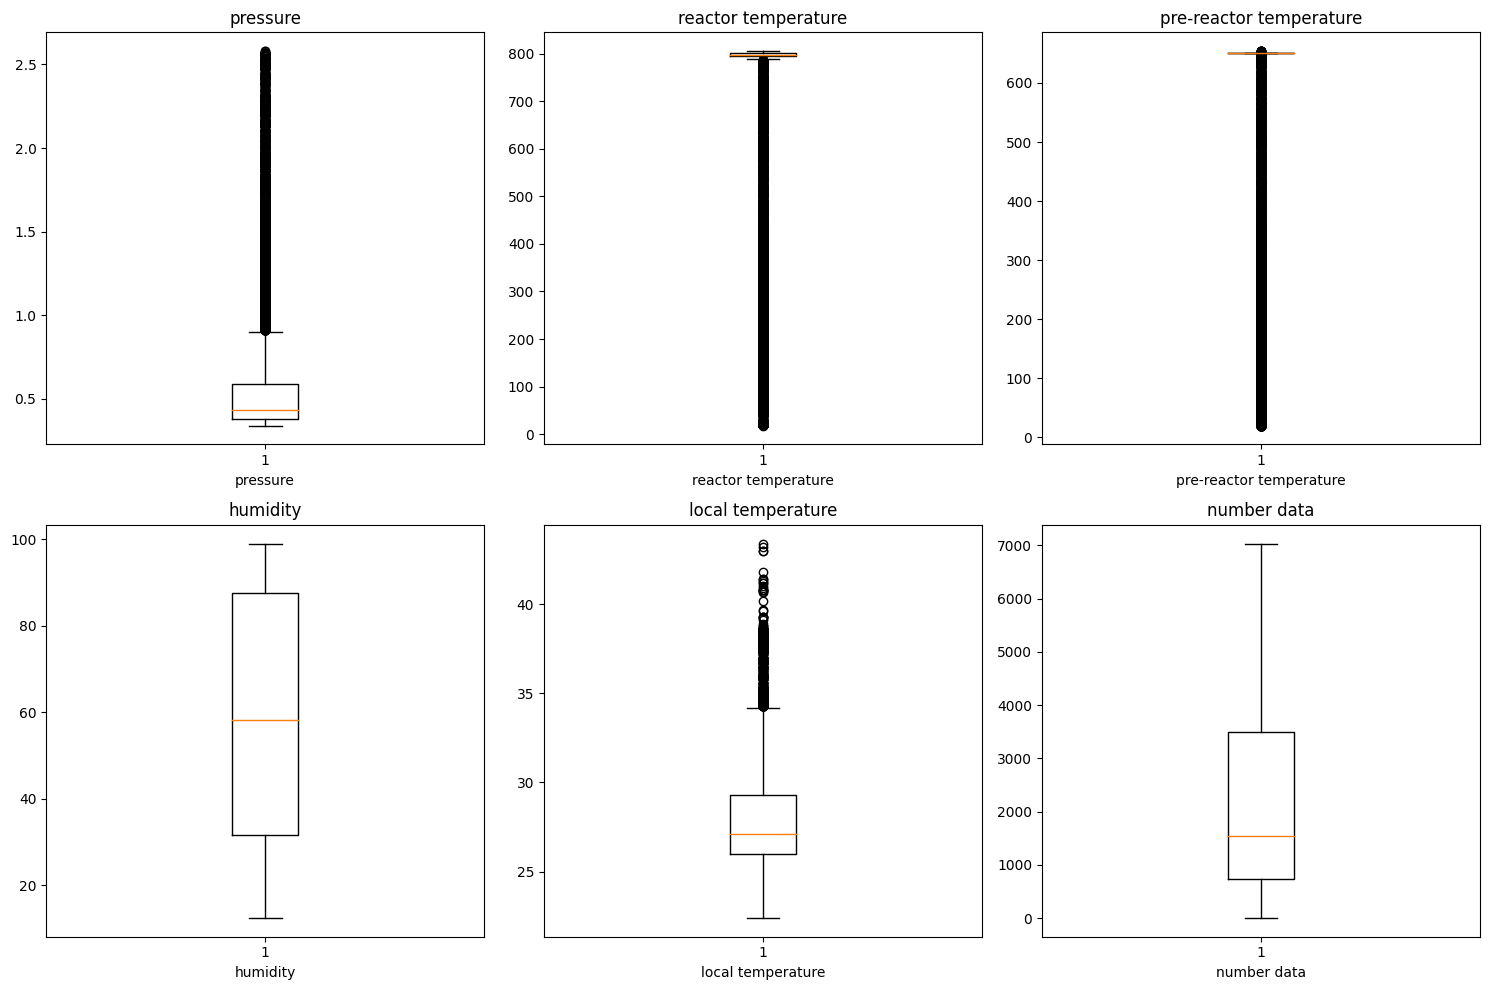

In [ ]:
def printBoxPlot(df_data, l_remove):
    num_columns = len(df_data.columns) - len(l_remove) # remove label and SMA pressure forecast
    num_rows = math.ceil(num_columns / 3)
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axs = axs.flatten()

    k = 0
    for i, column in enumerate(df_data.columns):
        if column not in l_remove:
            axs[i-k].boxplot(df_data[column].dropna())
            axs[i-k].set_title(f'{column}')
            axs[i-k].set_xlabel(f'{column}')
        else:
            k += 1

    for j in range(i-k+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

printBoxPlot(df_data=df_all, l_remove=['label', 'SMA pressure forecast'])


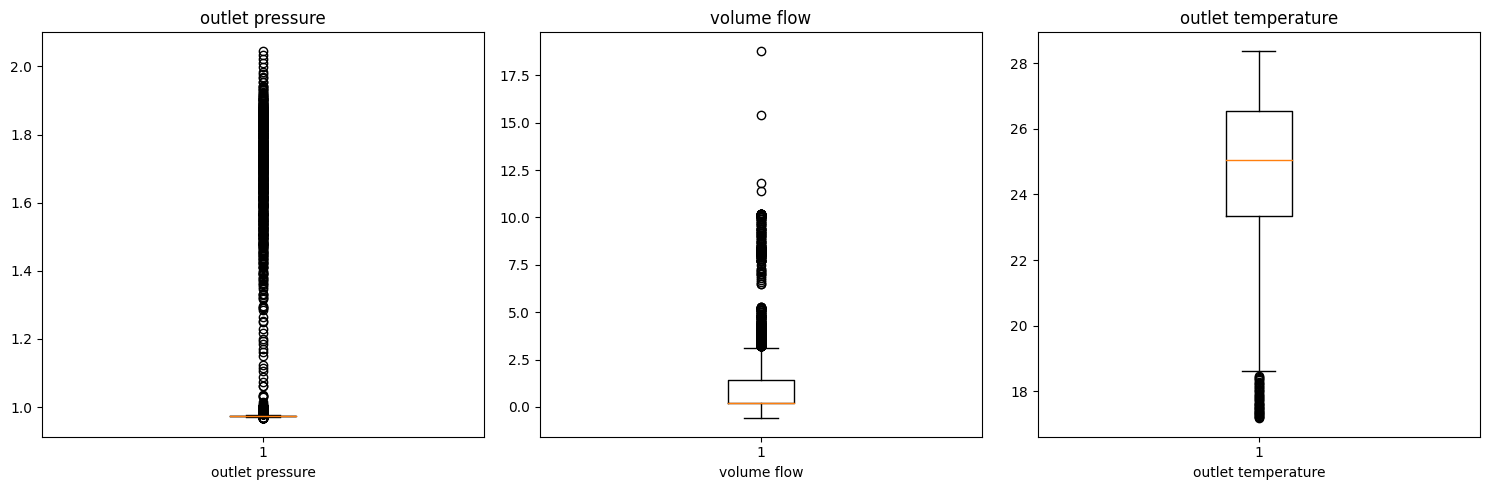

In [ ]:
printBoxPlot(df_data=df_all_flow, l_remove=['pressure', 'reactor temperature', 'pre-reactor temperature', 'humidity', 'local temperature', 'label', 'number data', 'SMA pressure forecast', 'mass flow'])

Simetria e curtose

- A umidade trás um simetria bem próxima a 0.
- O rotulo com uma simetria próxima a 0 nos apresenta uma boa distribuição entre os rotulos.
- A pressão, temperatura do reator e do pré-reator trás um alta curtose.
- A visualização da simetria e da curtose é possivel por meio do histograma.

In [ ]:
skewness = df_all.skew()
kurtosis = df_all.kurtosis()
stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
stats


,Skewness,Kurtosis
pressure,2.677626,7.350852
reactor temperature,-2.284833,3.457714
pre-reactor temperature,-2.248924,3.264561
humidity,0.015083,-1.633470
local temperature,1.087410,1.315148
label,0.045623,-1.410026
number data,0.825431,-0.381680
SMA pressure forecast,2.661161,7.291823


In [ ]:
skewness = df_all_flow.skew()
kurtosis = df_all_flow.kurtosis()
stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
stats.head(n=4)


,Skewness,Kurtosis
outlet pressure,1.898291,1.872754
volume flow,2.710372,7.971520
mass flow,3.300471,11.230496
outlet temperature,-0.786091,0.278053


Histograma

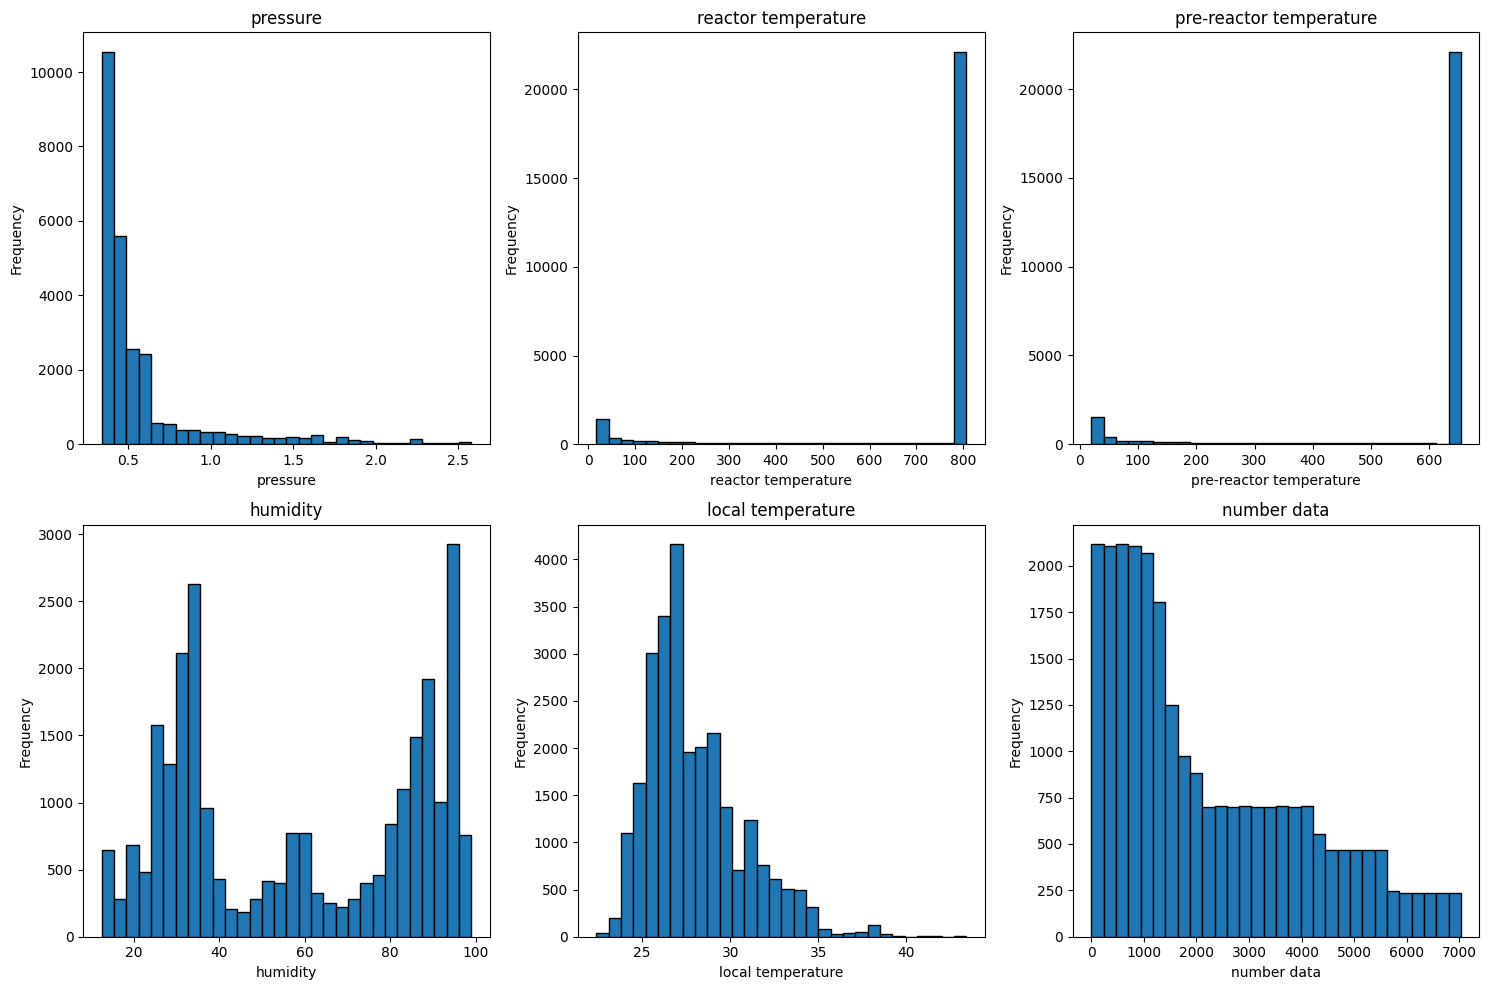

In [ ]:
def printHistogram(df_data, l_remove):
    num_columns = len(df_data.columns)- len(l_remove)
    num_rows = math.ceil(num_columns / 3)
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    k = 0
    for i, column in enumerate(df_data.columns):
        if column not in l_remove:
            axs[i-k].hist(df_data[column].dropna(), bins=30, edgecolor='black')
            axs[i-k].set_title(f'{column}')
            axs[i-k].set_xlabel(f'{column}')
            axs[i-k].set_ylabel('Frequency')
        else:
            k +=1

    # Removendo subplots vazios (se houver)
    for j in range(i-k+1, len(axs)):
        fig.delaxes(axs[j])

    # Ajustando o layout
    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

printHistogram(df_data=df_all, l_remove=['label', 'SMA pressure forecast'])

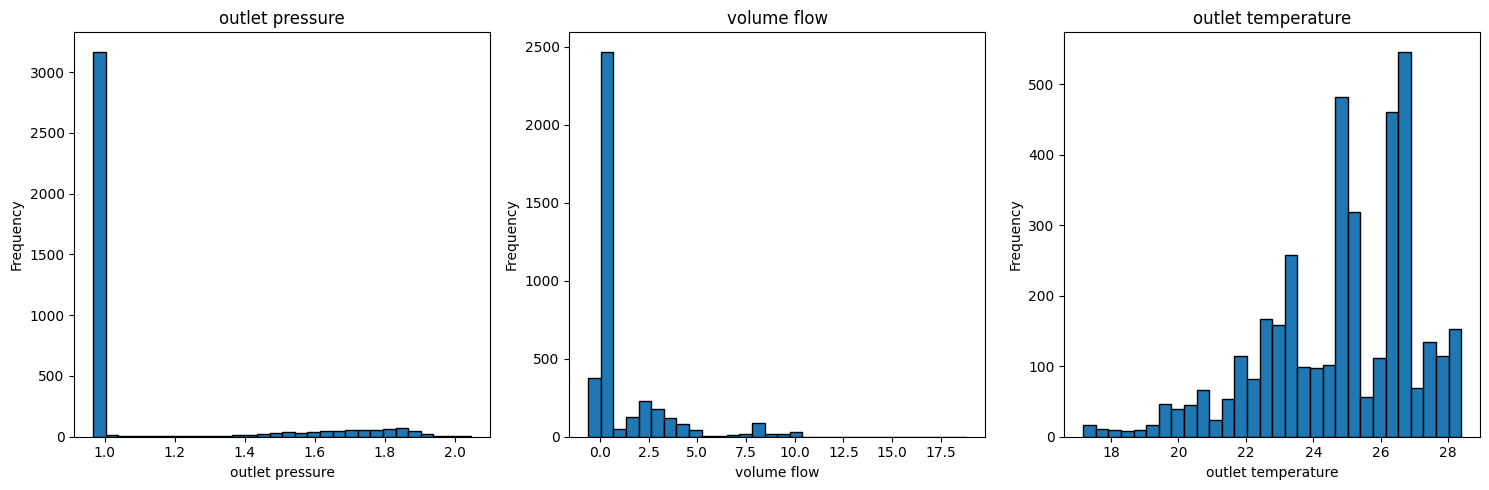

In [ ]:
printHistogram(df_data=df_all_flow, l_remove=['pressure', 'reactor temperature', 'pre-reactor temperature', 'humidity', 'local temperature', 'label', 'number data', 'SMA pressure forecast', 'mass flow'])

Normalidade

- Os resultados da aplicação do teste de Shapiro-Wilk a cada um dos campos nos conjuntos de dados, onde todas as colunas foram rejeitas.
- Impacto direto a modelos que assume normaldiade dos dados (Regressão Linear e Analise Discriminante Linear)
- Modelos que não exigem normalidade de dados podem ter melhor desempenho (Decision Tree, RandomForest e Gradient Boosting)

In [ ]:
for column in df_all.columns:
    stat, p = shapiro(df_all[column].dropna())
    print(f'Column: {column}, Stat: {stat:.4f}, p-value: {p}')
    if p > 0.05:
        print('Distribution seems normal (does not reject H0)\n')
    else:
        print('Distribution does not seem normal (rejects H0)\n')

In [9]:
result = []

for column in df_all_flow.columns:
    stat, p = shapiro(df_all_flow[column].dropna())
    result.append({'Column': column, 'Stat': stat, 'p-value': p, 'Normal': p > 0.05})

result_df = pd.DataFrame(result)

print(result_df)

                     Column      Stat       p-value  Normal
0           outlet pressure  0.498736  3.780704e-74   False
1               volume flow  0.572778  6.824646e-71   False
2                 mass flow  0.493156  2.234966e-74   False
3        outlet temperature  0.947611  4.454980e-35   False
4                  pressure  0.696180  3.380891e-64   False
5       reactor temperature  0.451575  5.159382e-76   False
6   pre-reactor temperature  0.449122  4.162891e-76   False
7                  humidity  0.814221  3.886213e-55   False
8         local temperature  0.891333  4.571683e-46   False
9                     label  0.667064  5.821848e-66   False
10              number data  0.962748  1.782680e-30   False
11    SMA pressure forecast  0.701603  1.537666e-63   False


Matriz de Correlação

- Excluindo a diagonal principal, apenas 9 das 28 correlações apresentam maiores valroes de correlação.
- Desconsiderar a alta correlação da media movel da pressão com a pressão, por ser um dado derivado do outro. (Por serem dados derivados a correlação presente em um, também ocorre no outro)
- Uma alta correlação entre a temperatura do pré-forno com a temperatura do pré-forno, devido ao seu comportamento espelhado durante a operação. (Lembrando de sua relêvancia, por se tratar de dados de pontos diferentes tendo resistencias individuais, quando pensamos de prevenção a falhas)


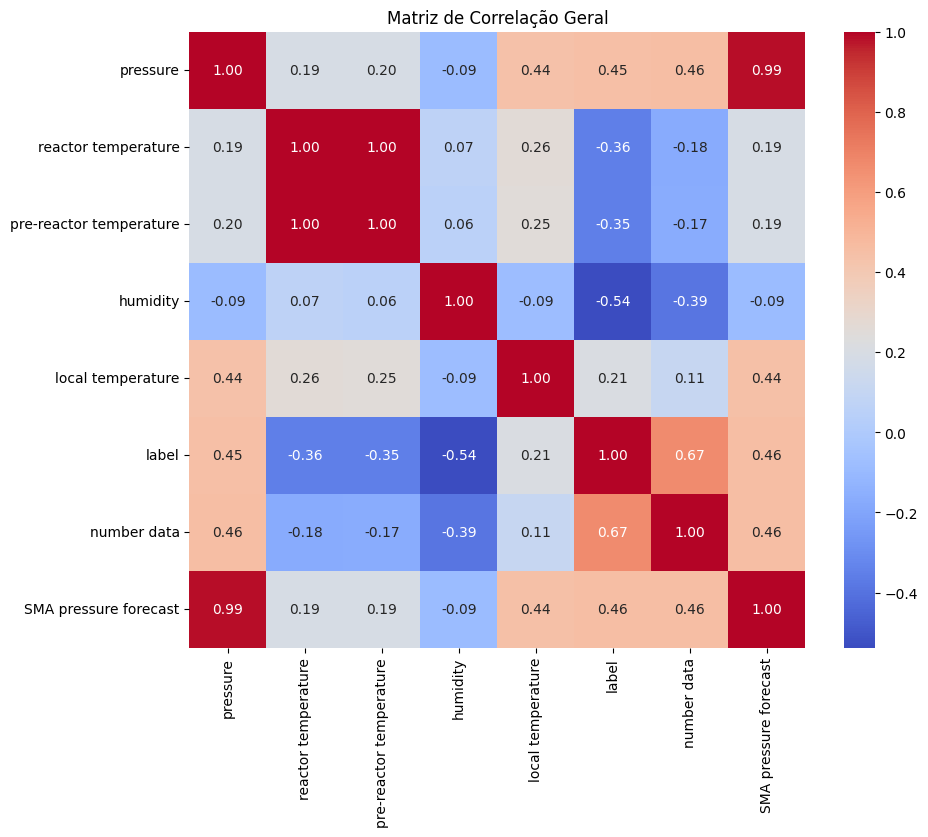

In [ ]:
def plotCorrelation(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
    plt.title('Matriz de Correlação Geral')
    plt.show()

plotCorrelation(df_all.corr())

Matriz de correlação individual das bases

- Além da correlação de cada base, também foi realizado um cluster entre elas por meio do kemeans. Foi definido um valor de 4 para o numero de clusters.

In [ ]:
def getAllCorrelation(dfs):
    lCorr = []
    lSamples = []
    for i, df in enumerate(dfs):
        corr = df.corr()
        lCorr.append(corr)
        lSamples.append(df.shape[0])
    return lCorr, lSamples


lCorr, lSample = getAllCorrelation(dfs=dfs)

In [ ]:
def getClusterCorrMatrix(lCorr, lSample):
    flattened_matrices = [matrix.values.flatten() for matrix in lCorr]
    from sklearn.cluster import KMeans

    # Definir o número de clusters desejados
    kmeans = KMeans(n_clusters=4, random_state=42)  # ajuste o número de clusters conforme necessário

    # Treinar o K-means com as matrizes normalizadas
    kmeans.fit(flattened_matrices)

    # Obter os rótulos dos clusters
    labels = kmeans.labels_
    dfCluster = pd.DataFrame({'Base': days, 'Cluster': labels, 'Corr':lCorr, 'Amostras':lSample})
    dfCluster = dfCluster.sort_values(by='Cluster')
    dfCluster = dfCluster.reset_index(drop=True)

    return dfCluster

dfCluster = getClusterCorrMatrix(lCorr, lSample)

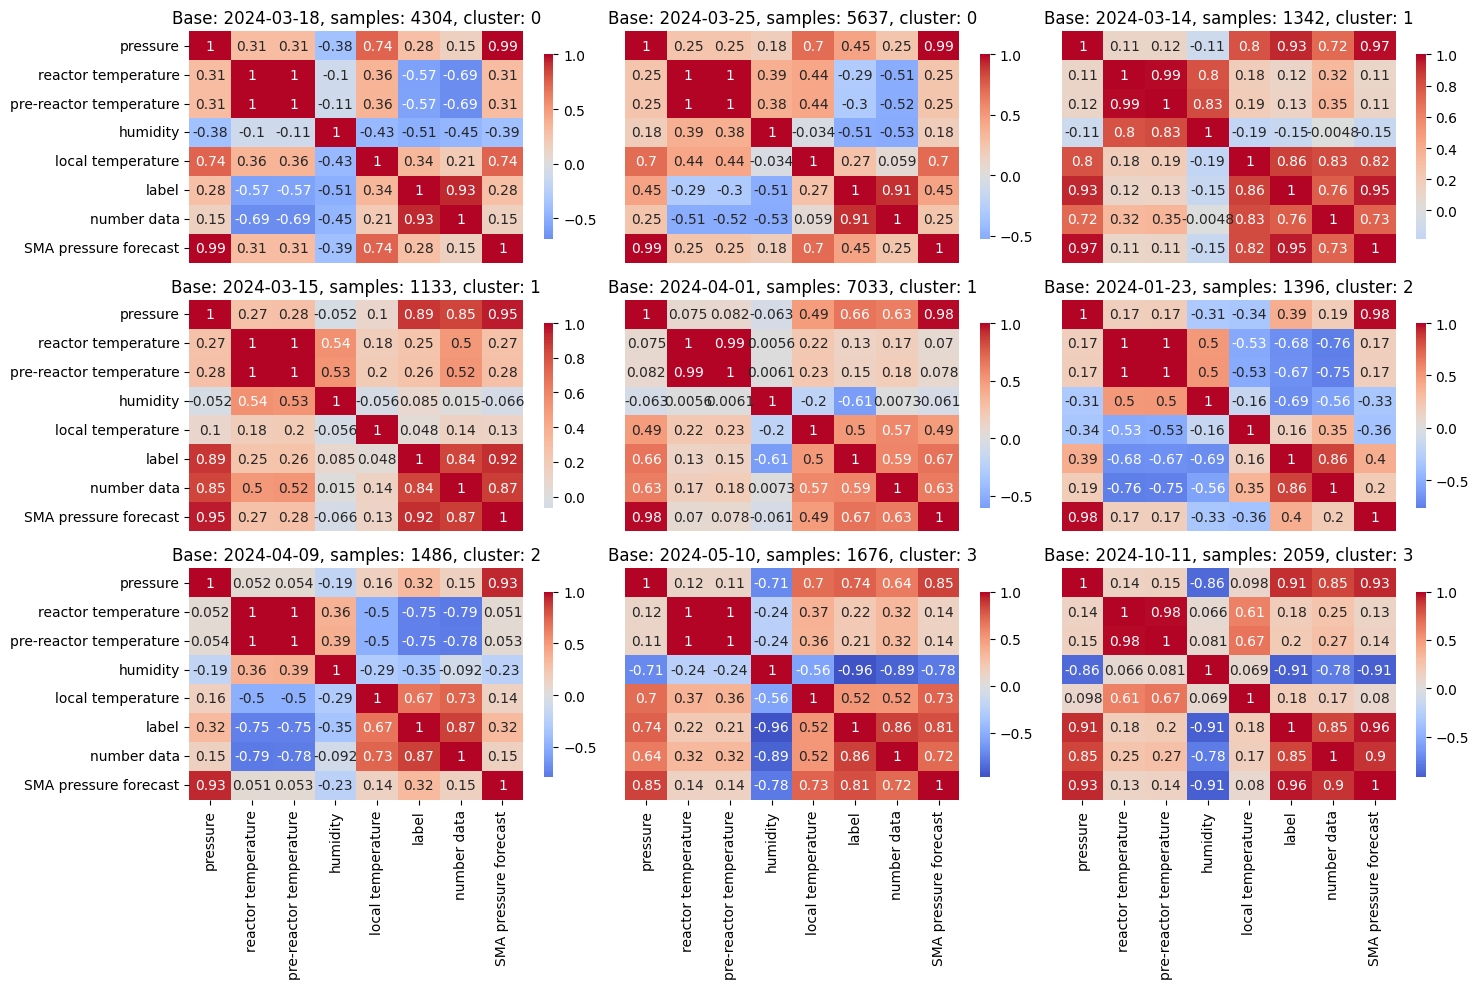

In [ ]:
def printCorrelationMatrix(dfCluster):
    plt.figure(figsize=(15, 10))

    # Iterar sobre as bases de dados e plotar os mapas de calor
    j=0

    for i in range(0,dfCluster.shape[0]):
        plt.subplot(3, 3, i + 1)  # Organizando em uma grade 3x3
        #print(df_ordenado['Corr'][i], " ", df_ordenado['Base'][i])
        corr = dfCluster['Corr'][i]

        if i<6:
            if i%3 !=0:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=[], yticklabels=[],
                            cbar_kws={"shrink": .8}, center=0)
            else:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=[], yticklabels=df.columns,
                            cbar_kws={"shrink": .8}, center=0)
        else:
            if i%3 !=0:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=df.columns, yticklabels=[],
                            cbar_kws={"shrink": .8}, center=0)
            else:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=df.columns, yticklabels=df.columns,
                            cbar_kws={"shrink": .8}, center=0)


        plt.title('Base: ' + dfCluster['Base'][i] + ', samples: '+str(dfCluster['Amostras'][i])+ ", cluster: " + str(dfCluster['Cluster'][i]))
        j+=1

    plt.tight_layout()  # Ajustar o layout para evitar sobreposição
    plt.show()

printCorrelationMatrix(dfCluster)

Matriz de Correlação com Vazao

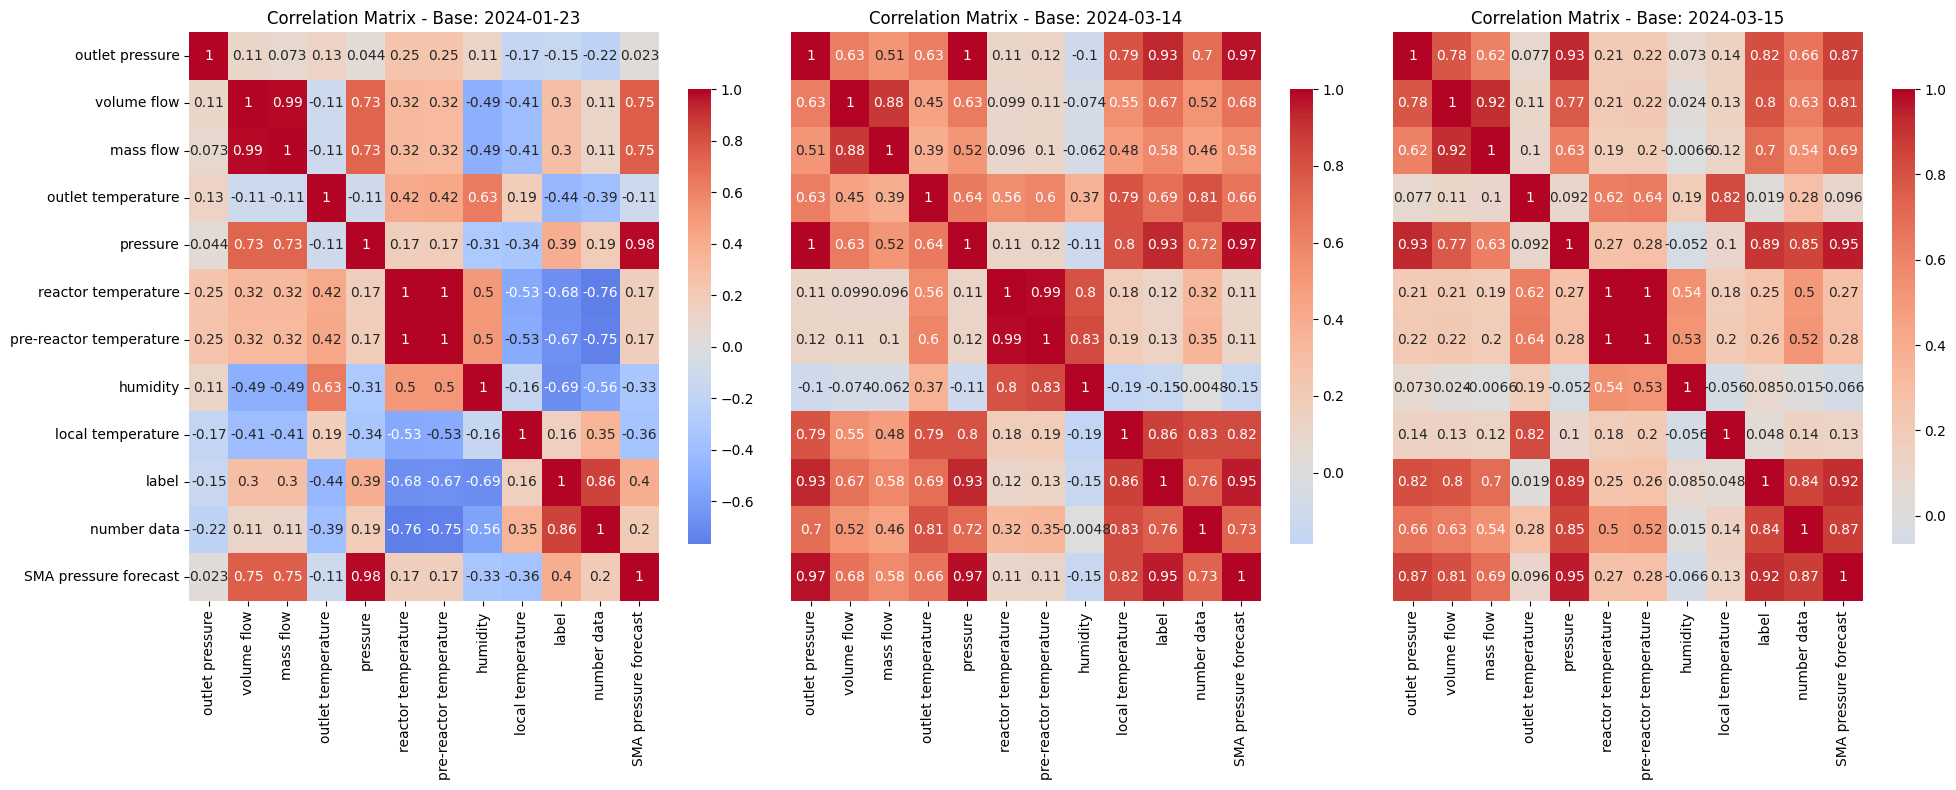

In [ ]:
plt.figure(figsize=(20, 8))

# Iterar sobre as bases de dados e plotar os mapas de calor
j=0
lCorr = []
lNAmostras = []
for i, df in enumerate(dfs_flow):
    plt.subplot(1, 3, i + 1)  # Organizando em uma grade 3x3
    corr = df.corr()  # Calcular a matriz de correlação
    lCorr.append(corr)
    lNAmostras.append(df.shape[0])
    if i==0:
        sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                xticklabels=df.columns, yticklabels=df.columns,
                cbar_kws={"shrink": .8}, center=0)
    else:
        sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                    xticklabels=df.columns, yticklabels=[],
                    cbar_kws={"shrink": .8}, center=0)


    plt.title('Correlation Matrix - Base: ' + days_flow[i])
    j+=1

plt.tight_layout()  # Ajustar o layout para evitar sobreposição
plt.show()

Grafico de dispersão

- Nos graficos a baixo são plotados as bases individuamente, com os dado de Pressão, Temperatura do reator, Temperatura do Pré-Reator e umidade (Os principais dados usados para a rotulagem das bases)

- A linhas tracejas na vertical separam os rotulos que identificam os status de operação.

- Mesmo sendo plotados individualmente, os dados foram normalizado com todas as bases juntas, devido a situações onde não ocorreu uma inconsitência. Assim obtivemos uma melhor representatividade do perdil dos dados para casa status de operação.

- Está sendo apresentado dois estilos de gráficos. (Gostariamos de sugestões)

In [ ]:
dataframes = []

for idx in [17, 21, 22, 23, 24, 26, 27, 30, 39]:
    df = pd.read_csv(f'/content/drive/MyDrive/data/BASES/finalVersion/base{idx}.csv')
    df = df.drop(['number data', 'local temperature', 'SMA pressure forecast'], axis=1)
    dataframes.append(df)

total_df = pd.concat(dataframes, ignore_index=True)

min_values = total_df.min()
max_values = total_df.max()
normalized_dfs = [(df - min_values) / (max_values - min_values) for df in dataframes]

description_map = {0: 'Activation', 1: 'Reaction', 2: 'Irregularity'}

<ipython-input-26-c6e4b27d7987>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(normalized_df.columns))


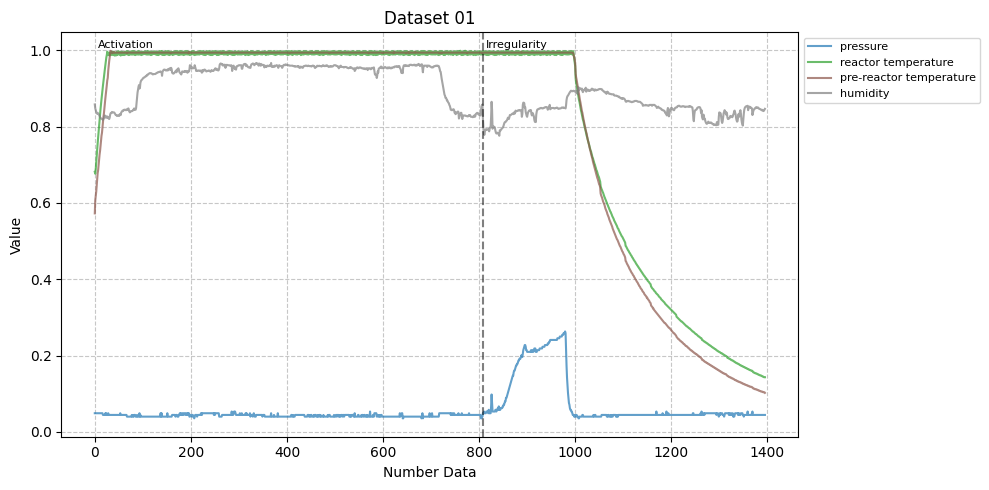

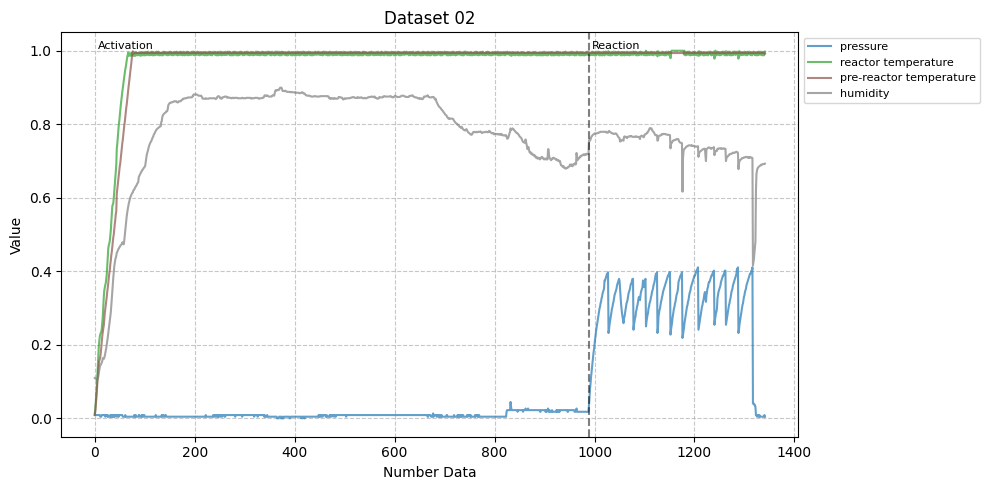

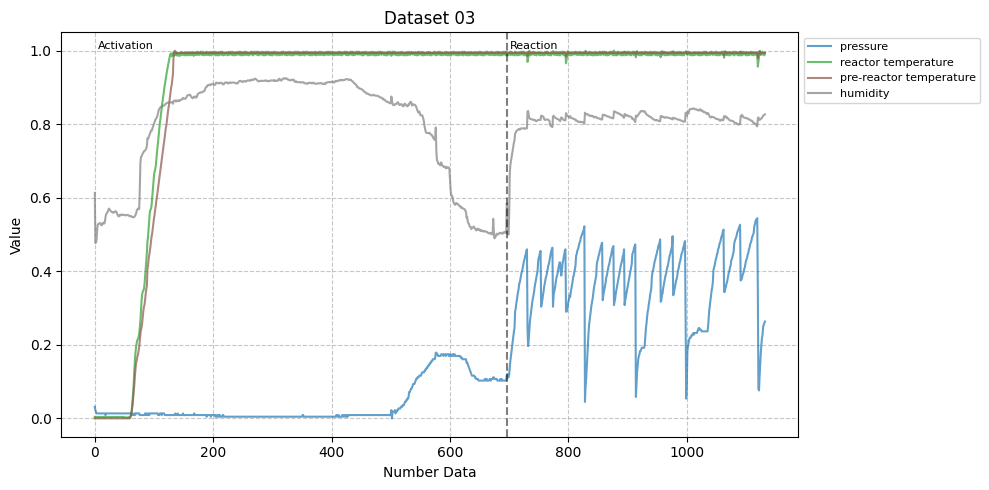

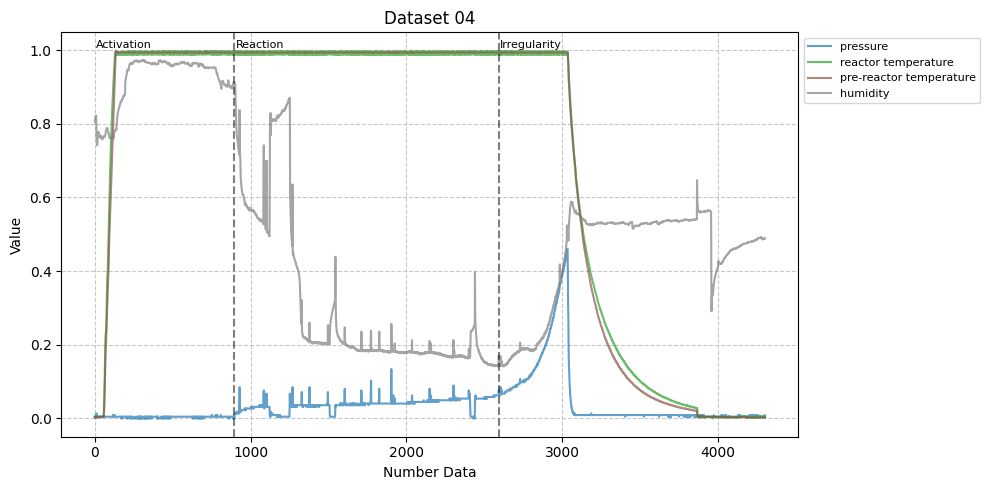

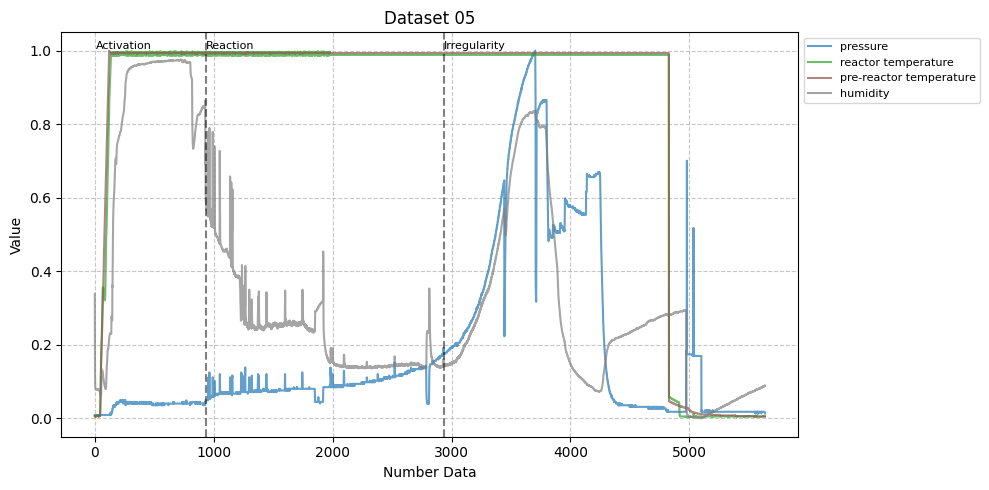

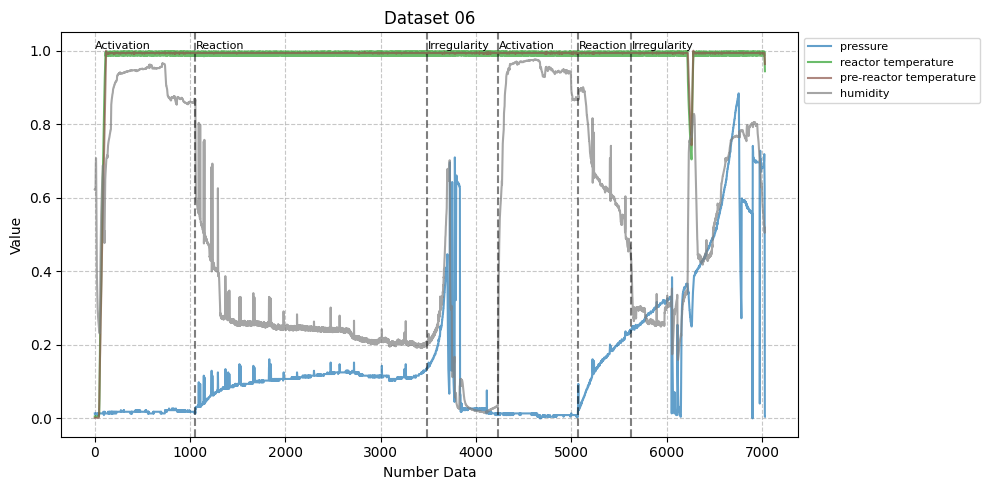

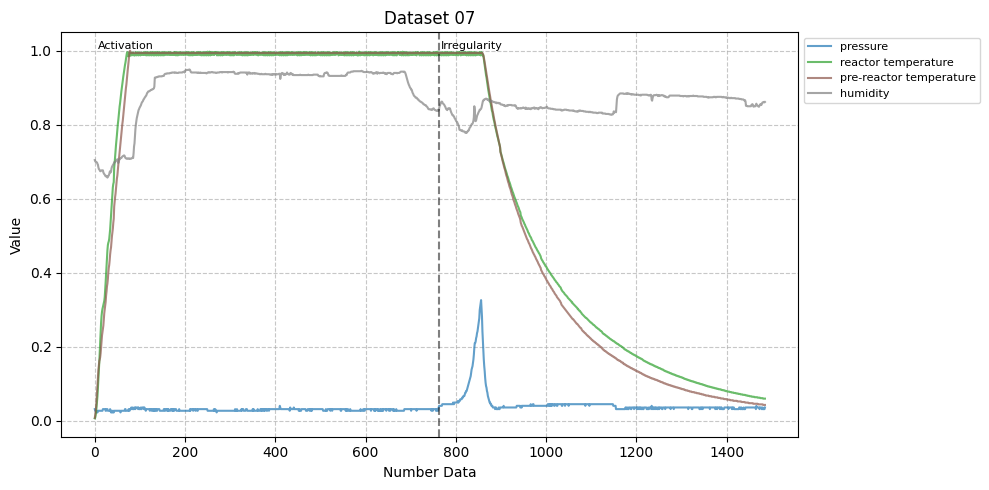

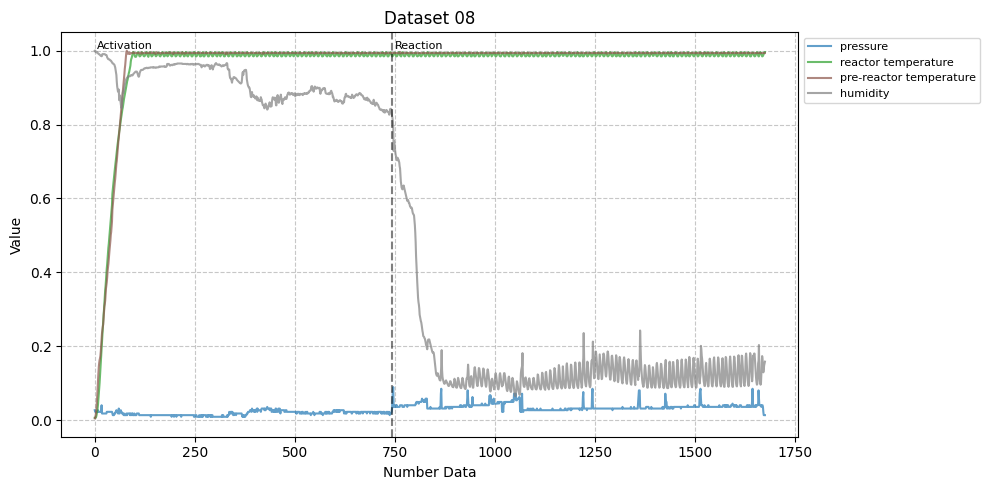

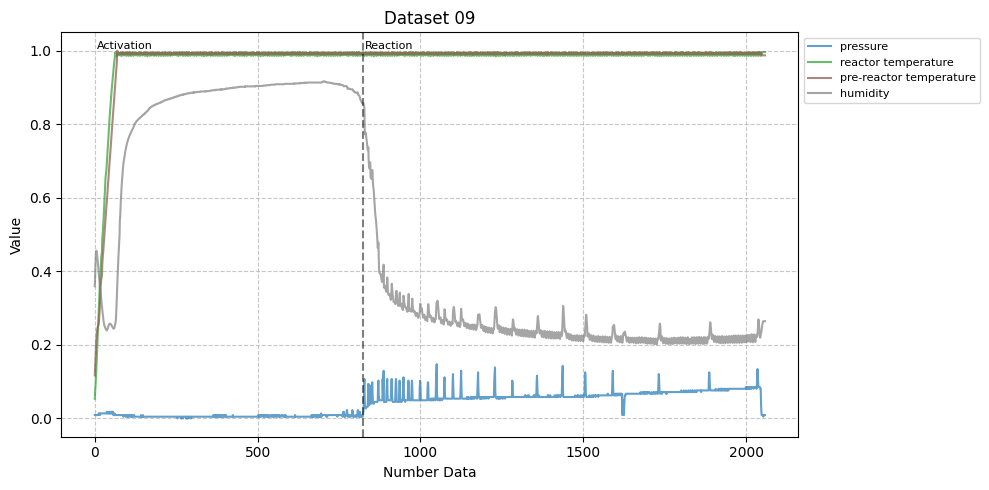

In [ ]:
def plot_data_1(dataset_idx, df, normalized_df):
    plt.figure(figsize=(10, 5))

    colors = plt.cm.get_cmap('tab10', len(normalized_df.columns))

    for idx, col in enumerate(normalized_df.columns):
        if col != 'label':
            plt.plot(normalized_df[col], label=col, color=colors(idx), alpha=0.7)

    previous_value = None
    first_label = True
    for i, value in enumerate(df['label']):
        if first_label:
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')
            first_label = False
        elif previous_value is not None and value != previous_value:
            plt.axvline(x=i, color='black', linestyle='--', alpha=0.5)
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')

        previous_value = value

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.title(f'Dataset {dataset_idx:02d}')
    plt.xlabel('Number Data')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

for idx, (dataset_idx, df, normalized_df) in enumerate(zip([1, 2, 3, 4, 5, 6, 7, 8, 9], dataframes, normalized_dfs)):
  plot_data_1(dataset_idx, df, normalized_df)

<ipython-input-27-1703fcde0a0a>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(normalized_df.columns))


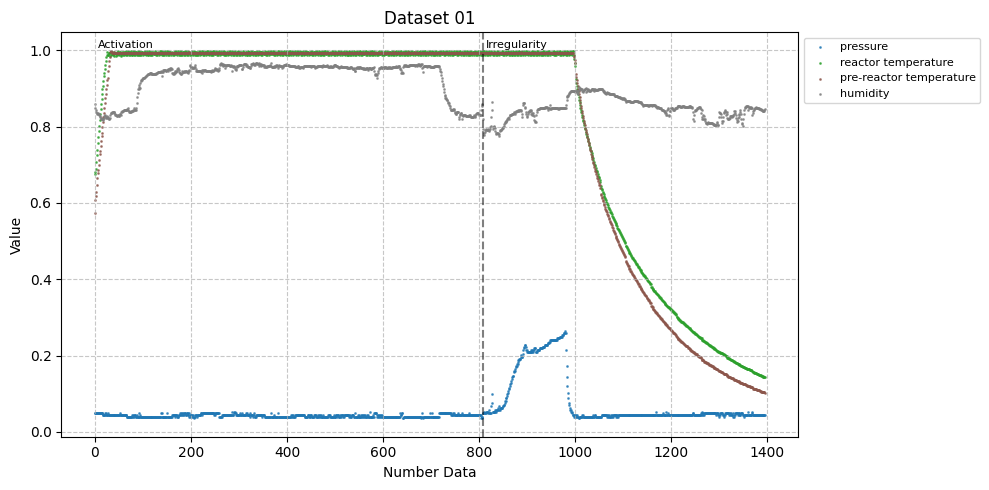

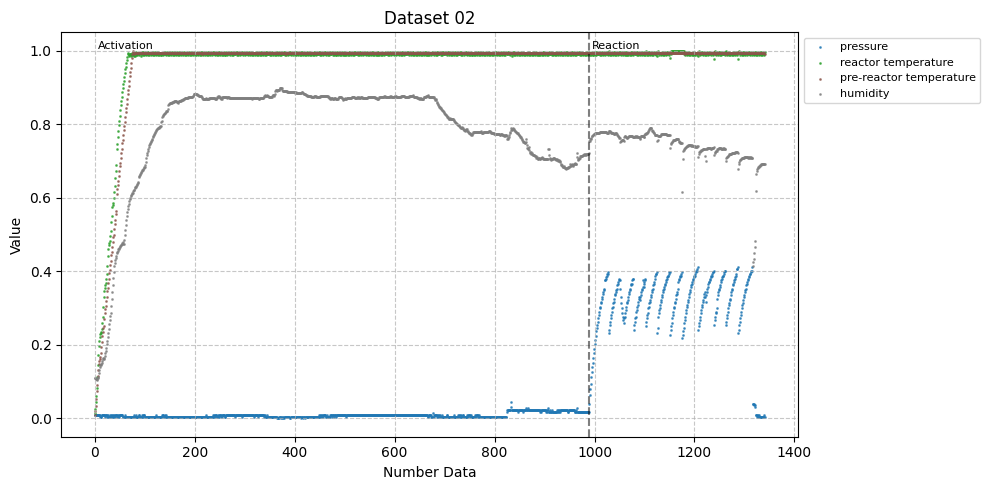

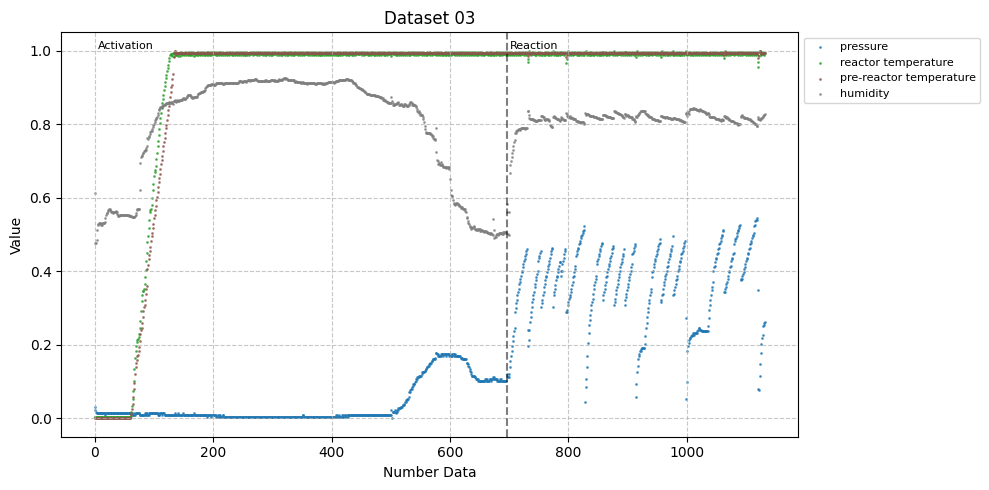

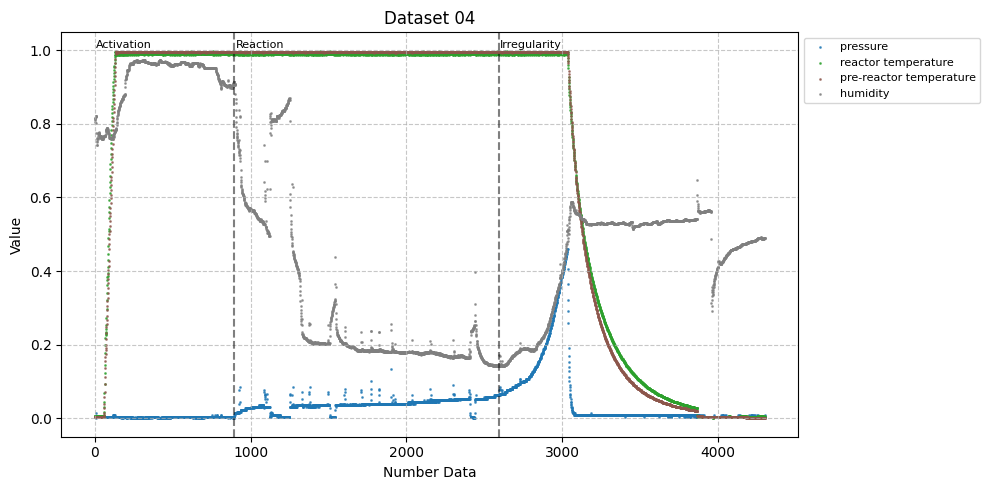

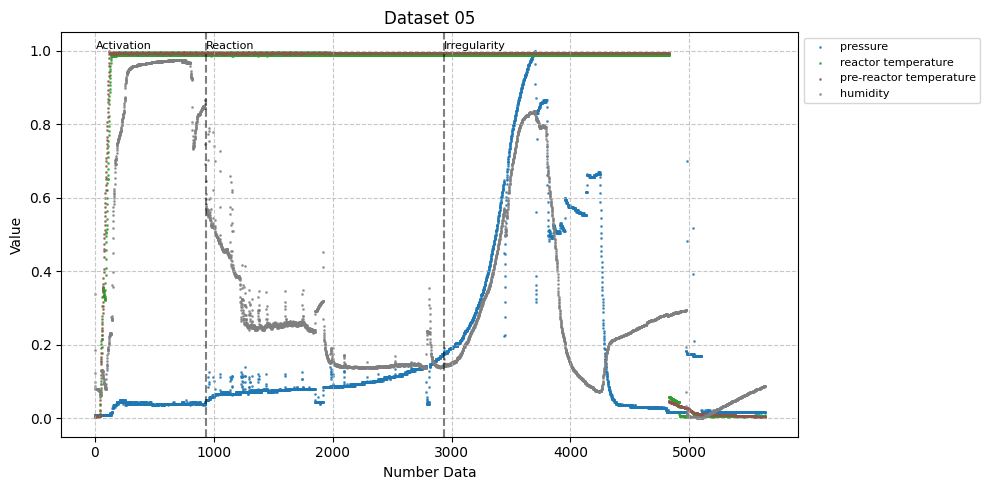

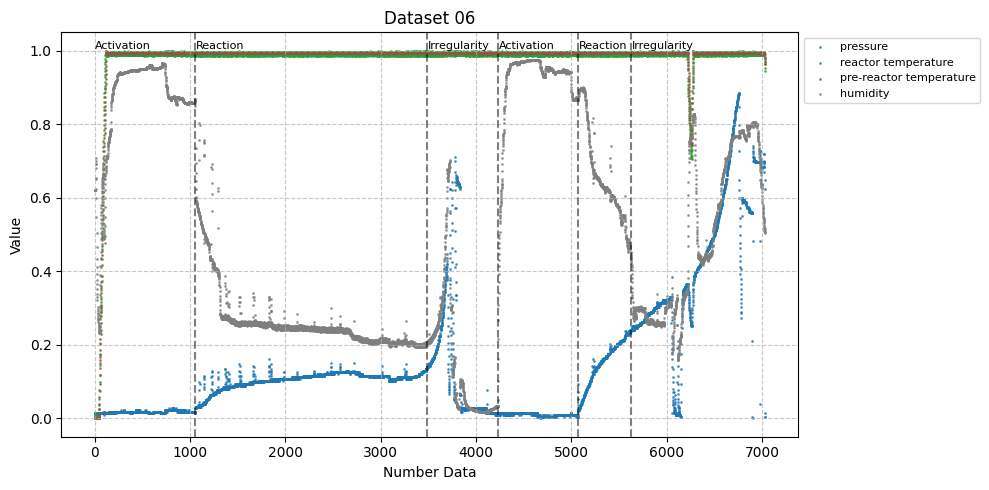

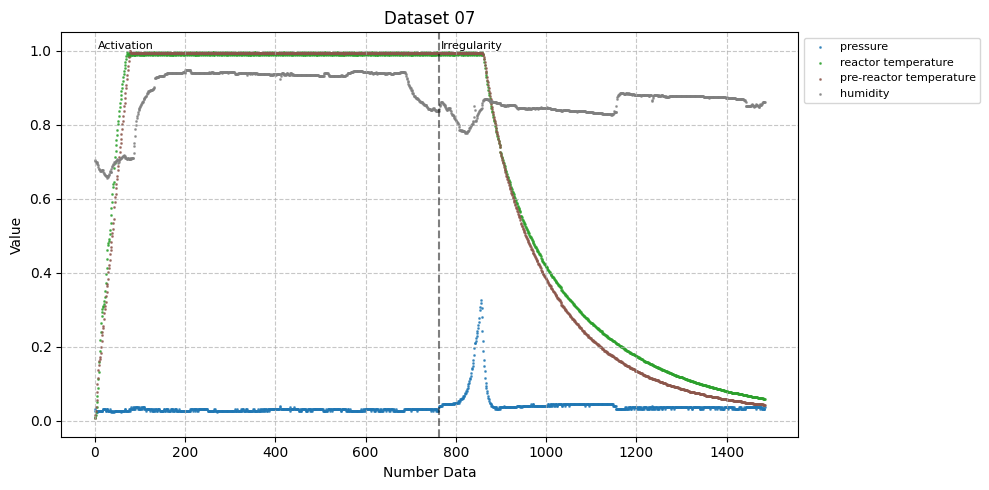

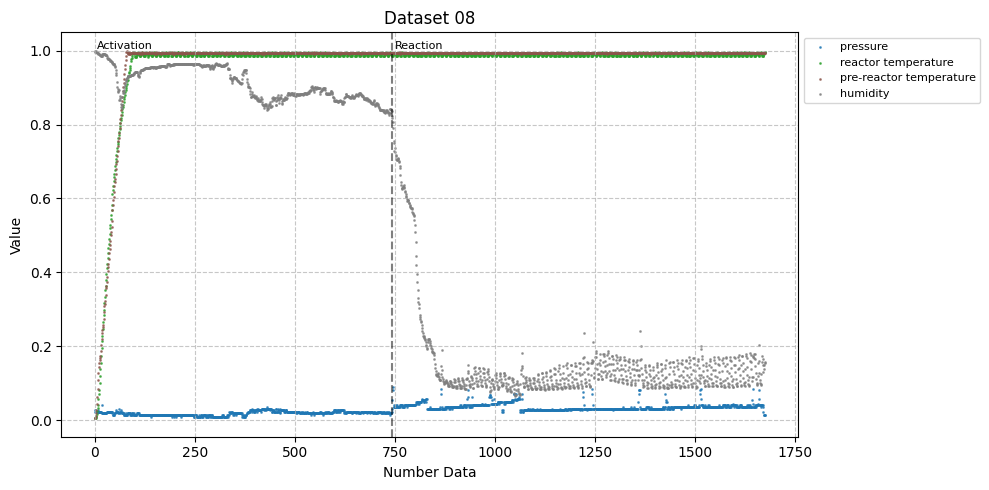

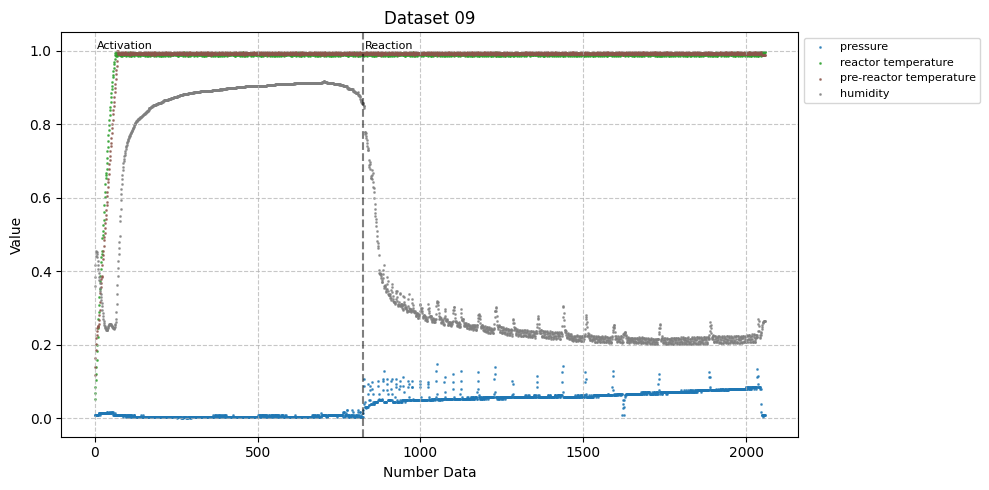

In [ ]:
def plot_data_2(dataset_idx, df, normalized_df):
    plt.figure(figsize=(10, 5))

    colors = plt.cm.get_cmap('tab10', len(normalized_df.columns))

    for idx, col in enumerate(normalized_df.columns):
        if col != 'label':
            plt.scatter(range(len(normalized_df[col])), normalized_df[col], label=col, color=colors(idx), s=1, alpha=0.7)

    previous_value = None
    first_label = True
    for i, value in enumerate(df['label']):
        if first_label:
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')
            first_label = False
        elif previous_value is not None and value != previous_value:
            plt.axvline(x=i, color='black', linestyle='--', alpha=0.5)
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')

        previous_value = value

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.title(f'Dataset {dataset_idx:02d}')
    plt.xlabel('Number Data')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

for idx, (dataset_idx, df, normalized_df) in enumerate(zip([1, 2, 3, 4, 5, 6, 7, 8, 9], dataframes, normalized_dfs)):
    plot_data_2(dataset_idx, df, normalized_df)